In [1]:
import pandas as pd
#import re
import numpy as np
import os
import json
#import builtins
from pathlib import Path
from typing import Tuple
from collections import defaultdict
#from glob import glob
#from zipfile import ZipFile
#import zipfile
import ruamel.yaml
from typing import Union
#import pathlib as pl#
#from pathlib import Path    
from scipy.optimize import curve_fit
#from scipy import signal
from scipy.signal import sawtooth

import matplotlib.pyplot as plt


# Dan's import

In [28]:


def yml_load(input: Union[str, Path]):
    """
    Load a YAML file or string.

    This function loads a YAML file or string using the ruamel.yaml library.
    It supports loading from a file path, a Path object, or a YAML string.

    Args:
        input (Union[str, Path]): The input YAML data. This can be a file path (str),
                                  a Path object, or a YAML string.

    Returns:
        obj: The loaded YAML data as a Python object.

    Raises:
        FileNotFoundError: If the input is a file path that does not exist.
        ruamel.yaml.YAMLError: If there is an error parsing the YAML data.
    """
    yaml = ruamel.yaml.YAML(typ="rt")
    yaml.version = (1, 2)
    if isinstance(input, Path):
        with input.open("r") as f:
            obj = yaml.load(f)
    elif os.path.exists(input):
        with open(input, "r") as f:
            obj = yaml.load(f)
    else:
        obj = yaml.load(input)
    return obj


def read_hlo(path: str, keep_keys: list = [], omit_keys: list = []) -> Tuple[dict, dict]:
    """
    Reads a .hlo file and returns its metadata and data.
    Args:
        path (str): The file path to the .hlo file.
    Returns:
        Tuple[dict, dict]: A tuple containing two dictionaries:
            - The first dictionary contains the metadata.
            - The second dictionary contains the data, where each key maps to a list of values.
    """
    if keep_keys and omit_keys:
        print("Both keep_keys and omit_keys are provided. keep_keys will take precedence.")
    
    path_to_hlo = Path(path)
    header_lines = []
    header_end = False
    data = defaultdict(list)

    with path_to_hlo.open() as f:
        for line in f:
            if line == "%%\n":
                header_end = True
            elif not header_end:
                header_lines.append(line)
            else:
                line_dict = json.loads(line)
                if keep_keys:
                    for k, v in line_dict.items():
                        if k in keep_keys:
                            if isinstance(v, list):
                                data[k] += v
                            else:
                                data[k].append(v)
                else:
                    for k, v in line_dict.items():
                        if k not in omit_keys:
                            if isinstance(v, list):
                                data[k] += v
                            else:
                                data[k].append(v)
    meta = dict(yml_load("".join(header_lines)))

    return meta, data




# getting the paths and importing them

In [3]:
def temporary_path_fn(match_str):
# use pathlib to get all files in the folder called test_data

    # PWD using pathlib
    path = Path.cwd().parent


    # move to the parent directory

    # add test_data to the path using pathlib
    path = os.path.join(path, "test_data")

    # get all files in the folder
    files = os.listdir(path)

    # return the file that contains "CV"
    spec_file= [file for file in files if match_str in file]

    # join path to the file
    spec_file = os.path.join(path, spec_file[0])

    return spec_file
    # read the file
    #meta, data = read_hlo(spec_file)#, keep_keys=["tick_time"])




# SpEC functions

In [ ]:


def generate_interpolation_function(CV: pd.DataFrame,
        startin_samp: float = 1, starting_phase: float = 0, starting_offset: float = 0,
        biologic: bool = True
    ):
        """
        This function works on an instance of the SpEC class where read_CV has been run.
        It takes in self.CV and fits a sawtooth function to the data by
        reading the collumns  't_s' and 'Ewe_V' and fits these functions
        to Sawtooth2 (defined below). It populates the interpolation attribute
        of self with fitting parameters needed to interpolate using sawtooth2. This can
        then be used to convert time to voltage in spectral data. If the fit is poor
        the user can adjust the starting amplitude and phase, most likley the issue
        is the amplitude - change this from -1 to 1

        inputs: CV a pd.DataFrame
        outputs: an tupple of fit values for sawtooth2
        """

        
        # extract the time and voltage data from the collumns 't_s' and 'Ewe_V'
        # as x_data and y_data respectively
        x_data = CV["t_s"]
        y_data = CV["Ewe_V"]
        max_cycles = int(CV["cycle"].max())
        if biologic:
            max_cycles = max_cycles + 1
        # Initial guess for the parameters [amplitude, phase], period is the max time
        initial_guess = [startin_samp, x_data.max() / max_cycles, starting_phase, starting_offset]

        # Fit the data to the custom sawtooth function
        popt, pcov = curve_fit(
            sawtooth2,
            x_data,
            y_data,
            p0=initial_guess,
            method="dogbox",
            maxfev=100000,  # Increase the number of iterations
        )
        # Extract the optimal parameters
        amplitude_fit, period_fit, phase_fit, offset_fit = popt

        # Print the fitted parameters

        # Generate fitted data
        y_fit = sawtooth2(x_data, amplitude_fit, period_fit, phase_fit, offset_fit)

        # Plot the original data and the fitted data
        fig, ax = plt.subplots()
        ax.plot(x_data, y_data, label="Original data")
        ax.plot(x_data, y_fit, color="red", linestyle="--", label="Fitted data")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Voltage (V)")
        # add a title of fitted vs measured time/ voltage
        plt.title("Interpolation function used to covert t to V")

        # add ledgend and place it on outside of plot on the right
        ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.show()

        interpolation = (amplitude_fit, period_fit, phase_fit, offset_fit)
        return interpolation

def sawtooth2(time, amplitude, period, phase, offset):
    """This helper function generates a sawtooth wave with the following parameters:
    Once, fitted is used to generate an interpolation function from t-->V.
    time: time array
    amplitude: amplitude of the wave
    period: period of the wave
    phase: phase of the wave (i.e. x offset)
    offset: Y offset of the wave

    returns: a voltage value or a voltage array
    """
    return (amplitude * sawtooth((2 * np.pi * time) / (period) - phase, 0.5) + offset)


def read_spec_times(spec_file_path: str) -> pd.DataFrame:
    data=pd.DataFrame(read_hlo(spec_file_path, keep_keys=["tick_time"])[1])
    data.iloc[:,0]=data.iloc[:,0]-data.iloc[0,0]
    return data

def interpolate_spec_time_to_U(spec_times:pd.DataFrame, interp_tup:tuple)->pd.DataFrame:
    """
    Interpolates the time column of the spec data to the time column of the U data using sawtooth2
    """
    calibration_df=pd.DataFrame()
    calibration_df["t_s"]=spec_times["tick_time"]
    calibration_df["Ewe_V"]=sawtooth2(spec_times["tick_time"], *interp_tup)
    return calibration_df


def remove_times_after_CV_end(spec_times:pd.DataFrame, CV:pd.DataFrame)->pd.DataFrame:
    """
    Removes all times after the last time in the CV data
    """
    spec_times=spec_times[spec_times["tick_time"]<CV["t_s"].max()]

    # also worth removing timesn before the first time in the CV data
    # in case triggering is from an external source - you should be
    # checking that your data is aligned properly.
    #spec_times=spec_times[spec_times["tick_time"]>CV["t_s"].min()]
    return spec_times

def generate_min_max_list_for_cycles(CV:pd.DataFrame)->list:
    """
    This function groups cycle. Looping through each cycle it finds the min and max time
    """
    min_max_dict={}
    for cycle, sub_frame in CV_data.groupby("cycle"):
        min_max_dict[cycle] =  [sub_frame["t_s"].min(), sub_frame["t_s"].max()]  
    return min_max_dict
    
def return_cycle_for_time(time:float, min_max_dict:dict)->int:
    """
    This function takes a time and returns the cycle it belongs to
    """
    for cycle, min_max in min_max_dict.items():
        if time >= min_max[0] and time <= min_max[1]:
            return cycle
    else:
        raise ValueError("Time not found in any cycle")
    return None

def get_cycles_for_spec_times(calibration_df:pd.DataFrame, CV_data:pd.DataFrame)->pd.DataFrame:
    """
    This function takes a spec times dataframe and returns a dataframe with the cycle number
    """

    min_max_dict=generate_min_max_list_for_cycles(CV_data)
    calibration_df["cycle"]=calibration_df["t_s"].apply(lambda x: return_cycle_for_time(x, min_max_dict))
    return calibration_df

ValueError: Time not found in any cycle

# testing

In [129]:
spec_file_path=temporary_path_fn("ANDOR")

spec_times[spec_times<(CV_data["t_s"].max()-0.01)].dropna()

,tick_time
0,0.000000
1,0.010200
2,0.020401
3,0.030601
4,0.040801
...,...
23512,239.830348
23513,239.840548
23514,239.850748
23515,239.860949


In [45]:

CV_path=temporary_path_fn("CV")
CV_data=pd.DataFrame(read_hlo(CV_path, keep_keys=['Ewe_V', 'I_A', 't_s', 'cycle'] )[1])
CV_data

,Ewe_V,I_A,t_s,cycle
0,0.341244,0.000396,0.000090,0
1,0.155376,-0.000299,0.100485,0
2,0.160406,-0.000173,0.200880,0
3,0.165414,-0.000121,0.301275,0
4,0.170390,-0.000092,0.401715,0
...,...,...,...,...
2385,0.176059,-0.000062,239.485909,4
2386,0.170973,-0.000060,239.586304,4
2387,0.166037,-0.000059,239.686744,4
2388,0.160959,-0.000058,239.787139,4


In [97]:
spec_times=read_spec_times(spec_file_path)
spec_times=remove_times_after_CV_end(spec_times, CV_data)

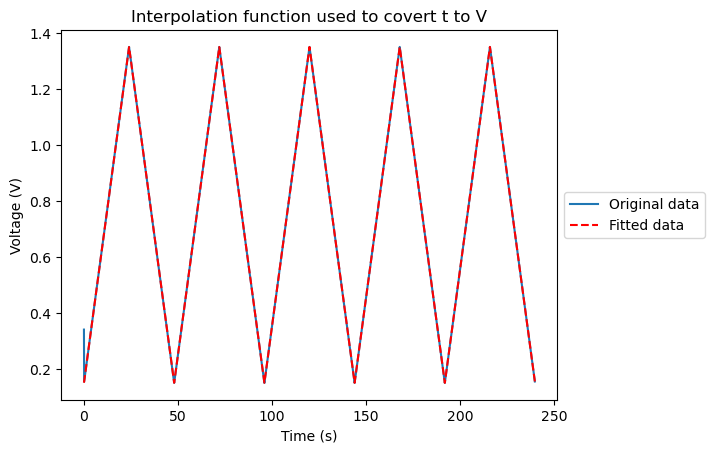

ValueError: Time not found in any cycle

In [98]:
interp_tup=generate_interpolation_function(CV_data)

calibration_df=interpolate_spec_time_to_U(spec_times, interp_tup)
calibration_df=get_cycles_for_spec_times(calibration_df, CV_data)


In [92]:
CV_data

,Ewe_V,I_A,t_s,cycle
0,0.341244,0.000396,0.000090,0
1,0.155376,-0.000299,0.100485,0
2,0.160406,-0.000173,0.200880,0
3,0.165414,-0.000121,0.301275,0
4,0.170390,-0.000092,0.401715,0
...,...,...,...,...
2385,0.176059,-0.000062,239.485909,4
2386,0.170973,-0.000060,239.586304,4
2387,0.166037,-0.000059,239.686744,4
2388,0.160959,-0.000058,239.787139,4


In [99]:
calibration_df

,t_s,Ewe_V
0,0.000000,0.151651
1,0.010200,0.151141
2,0.020401,0.151263
3,0.030601,0.151773
4,0.040801,0.152283
...,...,...
23513,239.840548,0.158431
23514,239.850748,0.157921
23515,239.860949,0.157412
23516,239.871149,0.156902


In [ ]:
def get_min_max_times_of_cycle(CV_df:pd.DataFrame, cycle:int)->Tuple[float, float]:
    """
    This function takes in a dataframe of a CV and a cycle number and returns the min and max times of that cycle
    """
    # get the max time of the cycle
    max_time=CV_df[CV_df["cycle"]==cycle]["t_s"].max()
    # get the min time of the cycle
    min_time=CV_df[CV_df["cycle"]==cycle]["t_s"].min()
    return min_time, max_time



# test